In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os

In [3]:
base_path = "/content/drive/My Drive/Msc Thesis/Clinical Significance/"

no_cs_path = 'No Clinical Significance'
mild_cs_path = 'Mild Clinical Significance'
serious_cs_path = 'Serious Clinical Significance'

no_cs = os.listdir(base_path + no_cs_path)
mild_cs = os.listdir(base_path + mild_cs_path)
serious_cs = os.listdir(base_path + serious_cs_path)

In [4]:
print("There are ", len(no_cs), " MRI images with No Clinical Significance")
print("There are ", len(mild_cs), " MRI images with Mild Clinical Significance")
print("There are ", len(serious_cs), " MRI images with Serious Clinical Significance")

There are  2531  MRI images with No Clinical Significance
There are  2075  MRI images with Mild Clinical Significance
There are  2509  MRI images with Serious Clinical Significance


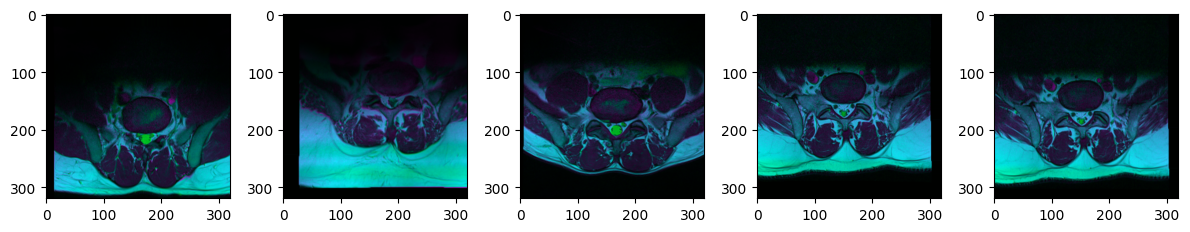

In [5]:
def visualize_image(sub_path, cs_status):
  plt.figure(figsize = (12,12))
  for i in range(5):
      plt.subplot(1, 5 , i+1)
      img = cv2.imread(base_path + sub_path + "/" + cs_status[i])
      plt.imshow(img)
      plt.tight_layout()
  plt.show()

## Visualization for MRI scans with No Clinical Significance
visualize_image(no_cs_path, no_cs)

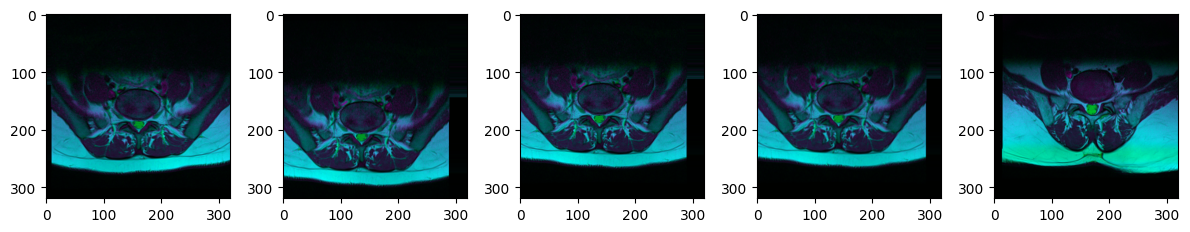

In [6]:
## Visualization for MRI scans with Mild Clinical Significance
visualize_image(mild_cs_path, mild_cs)

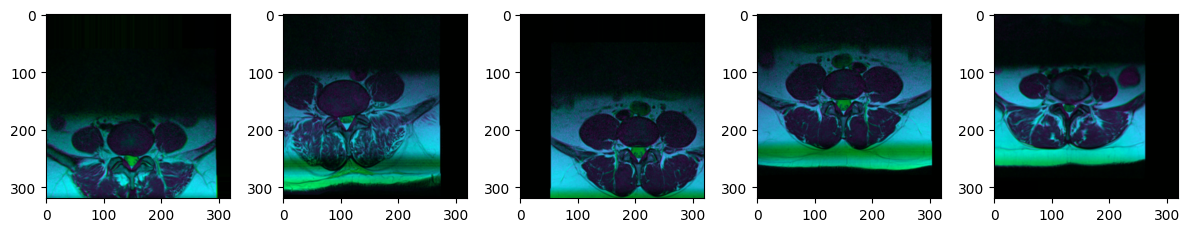

In [7]:
## Visualization for MRI scans with Serious Clinical Significance
visualize_image(serious_cs_path, serious_cs)

### Load and Process Images

In [8]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [9]:
class_folders = [no_cs_path, mild_cs_path, serious_cs_path]

# Function to load and process images for multiclass classification
def process_images(base_path, class_folders):
    images = []
    labels = []
    for class_idx, class_folder in enumerate(class_folders):
        class_dir = os.path.join(base_path, class_folder)
        for filename in os.listdir(class_dir):
            if filename.endswith(".png"):  # Adjust the file extension if needed
                img = load_img(os.path.join(class_dir, filename), target_size=(150, 150))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_idx)
    return images, labels

all_images, all_labels = process_images(base_path, class_folders)

# convert labels to categorical format
categorical_labels = to_categorical(all_labels, num_classes=len(class_folders))

In [10]:
all_images = np.array(all_images)
categorical_labels = np.array(categorical_labels)

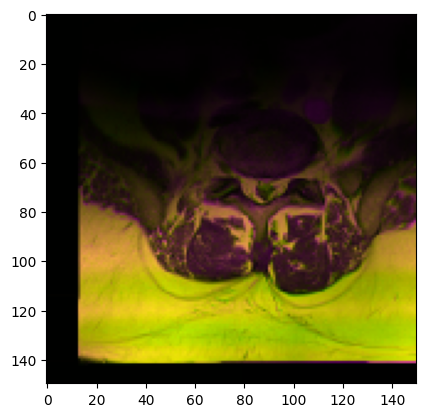

In [11]:
plt.imshow(all_images[1])
plt.show()

### Save Images and Labels

In [12]:
np.save('/content/drive/My Drive/Msc Thesis/cs_images.npy', all_images)

In [13]:
np.save('/content/drive/My Drive/Msc Thesis/cs_labels.npy', categorical_labels)

### Load Images and Labels

In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

all_images = np.load('/content/drive/My Drive/Msc Thesis/cs_images.npy')

In [15]:
categorical_labels = np.load('/content/drive/My Drive/Msc Thesis/cs_labels.npy')

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, categorical_labels, test_size=0.2, random_state=42)

In [17]:

print(f'Shape of training image : {X_train.shape}')
print(f'Shape of validation image : {X_test.shape}')
print(f'Shape of training labels : {y_train.shape}')
print(f'Shape of validation labels : {y_test.shape}')


Shape of training image : (5692, 150, 150, 3)
Shape of validation image : (1423, 150, 150, 3)
Shape of training labels : (5692, 3)
Shape of validation labels : (1423, 3)


### Build and Train the Model

In [18]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Cropping2D, Flatten, Dropout
from keras import optimizers

In [19]:
# Build the  model
ClinicalSignificance_model = Sequential()

# Add cropping layer
ClinicalSignificance_model.add(tf.keras.layers.Cropping2D(cropping=((45, 25), (25, 25)), input_shape=(150, 150, 3))) # cropping=((top_crop, bottom_crop), (left_crop, right_crop))

# Convolutional and Pooling layers
ClinicalSignificance_model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
ClinicalSignificance_model.add(MaxPooling2D(pool_size=(2, 2)))
ClinicalSignificance_model.add(Dropout(0.2))

ClinicalSignificance_model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
ClinicalSignificance_model.add(MaxPooling2D(pool_size=(2, 2)))
ClinicalSignificance_model.add(Dropout(0.2))

ClinicalSignificance_model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
ClinicalSignificance_model.add(MaxPooling2D(pool_size=(2, 2)))
ClinicalSignificance_model.add(Dropout(0.2))

ClinicalSignificance_model.add(Conv2D(512, (3, 3), activation="relu", padding='same'))
ClinicalSignificance_model.add(MaxPooling2D(pool_size=(2, 2)))
ClinicalSignificance_model.add(Dropout(0.2))

# Flatten and Fully Connected layers
ClinicalSignificance_model.add(Flatten())
ClinicalSignificance_model.add(Dense(512, activation='relu'))
# ClinicalSignificance_model.add(Dropout(0.2))
ClinicalSignificance_model.add(Dense(256, activation='relu'))
# ClinicalSignificance_model.add(Dropout(0.2))
ClinicalSignificance_model.add(Dense(128, activation='relu'))

ClinicalSignificance_model.add(Dense(64, activation='relu'))

# Output layer
ClinicalSignificance_model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
ClinicalSignificance_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
ClinicalSignificance_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d (Cropping2D)     (None, 80, 100, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 80, 100, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 50, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 40, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 25, 128)       0         
 g2D)                                                   

In [20]:
from keras.callbacks import ModelCheckpoint

# Save the best model
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Msc Thesis/saved_model/cs.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = ClinicalSignificance_model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), callbacks=[model_checkpoint])

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3530

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 15s 188ms/step - loss: 1.0983 - accuracy: 0.3530 - val_loss: 1.0937 - val_accuracy: 0.3450
Epoch 2/50
45/45 [==============================] - 5s 118ms/step - loss: 1.0951 - accuracy: 0.3872 - val_loss: 1.0907 - val_accuracy: 0.4462
Epoch 3/50
45/45 [==============================] - 5s 113ms/step - loss: 1.0599 - accuracy: 0.4515 - val_loss: 1.0904 - val_accuracy: 0.3928
Epoch 4/50
45/45 [==============================] - 5s 118ms/step - loss: 0.9847 - accuracy: 0.5190 - val_loss: 0.9362 - val_accuracy: 0.5580
Epoch 5/50
45/45 [==============================] - 5s 119ms/step - loss: 0.9268 - accuracy: 0.5631 - val_loss: 0.8640 - val_accuracy: 0.6008
Epoch 6/50
45/45 [==============================] - 5s 120ms/step - loss: 0.8759 - accuracy: 0.6019 - val_loss: 0.8036 - val_accuracy: 0.6571
Epoch 7/50
45/45 [==============================] - 5s 114ms/step - loss: 0.8143 - accuracy: 0.6295 - val_loss: 0.8329 - val_accuracy: 0.6416
Epoch 8/50
45/45

### Load Model

In [21]:
from tensorflow.keras.models import load_model

ClinicalSignificance_model = load_model("/content/drive/My Drive/Msc Thesis/saved_model/cs.h5")

### Model Evaluation

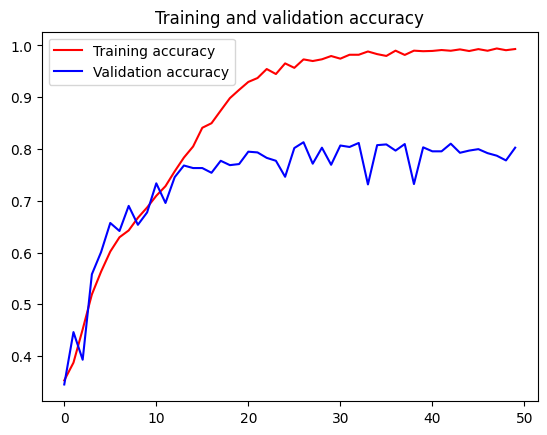

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

45/45 [==============================] - 1s 8ms/step


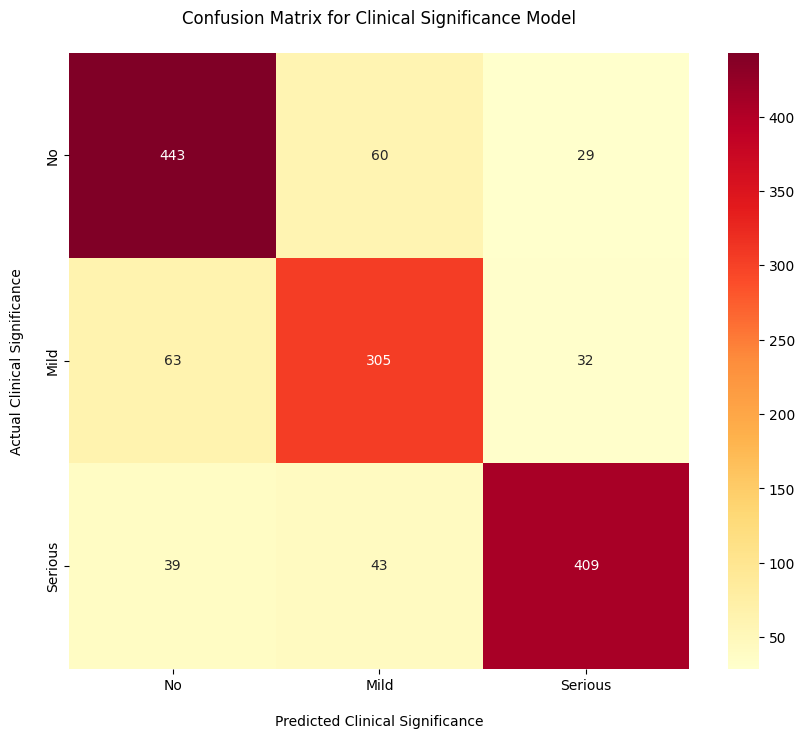

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predicted labels (assuming your model outputs class probabilities)
y_pred_probs = ClinicalSignificance_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Create confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)  # Convert one-hot encoded labels to class labels

# Create heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figsize as needed
sns.heatmap(cm, annot=True, fmt=".0f", cmap='YlOrRd')

# Add class labels and title
class_labels = ['No', 'Mild', 'Serious']  # Adjust based on your class names
plt.xticks(np.arange(len(class_labels))+0.5, class_labels)
plt.yticks(np.arange(len(class_labels))+0.5, class_labels)
plt.xlabel('\nPredicted Clinical Significance')
plt.ylabel('Actual Clinical Significance\n')
plt.title('Confusion Matrix for Clinical Significance Model\n')

# Show the plot
plt.show()


In [25]:
from sklearn.metrics import classification_report

# Get predicted labels (the model outputs class probabilities)
y_pred_probs = ClinicalSignificance_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Print classification report
class_labels = ['No', 'Mild', 'Serious']
target_names = [f'{label} Clinical Significance' for label in class_labels]
cm_evaluation = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(cm_evaluation)


45/45 [==============================] - 0s 8ms/step
                               precision    recall  f1-score   support

     No Clinical Significance       0.81      0.83      0.82       532
   Mild Clinical Significance       0.75      0.76      0.75       400
Serious Clinical Significance       0.87      0.83      0.85       491

                     accuracy                           0.81      1423
                    macro avg       0.81      0.81      0.81      1423
                 weighted avg       0.81      0.81      0.81      1423



### LIME Image Explainer

In [26]:
#pip install lime

In [27]:
import lime
from lime import lime_image

# Import mark_boundaries function
from skimage.segmentation import mark_boundaries

In [28]:
# Using LIME Image Explainer
image_to_explain = X_test[10]                # Replace this with the image you want to explain


def predict(image_array):
    return ClinicalSignificance_model.predict(image_array)

# Create a LimeImageExplainer object
explainer = lime_image.LimeImageExplainer()

# Generate an explanation for the image
explanation = explainer.explain_instance(
    image_to_explain,
    predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


#### Superpixel for the top most Prediction

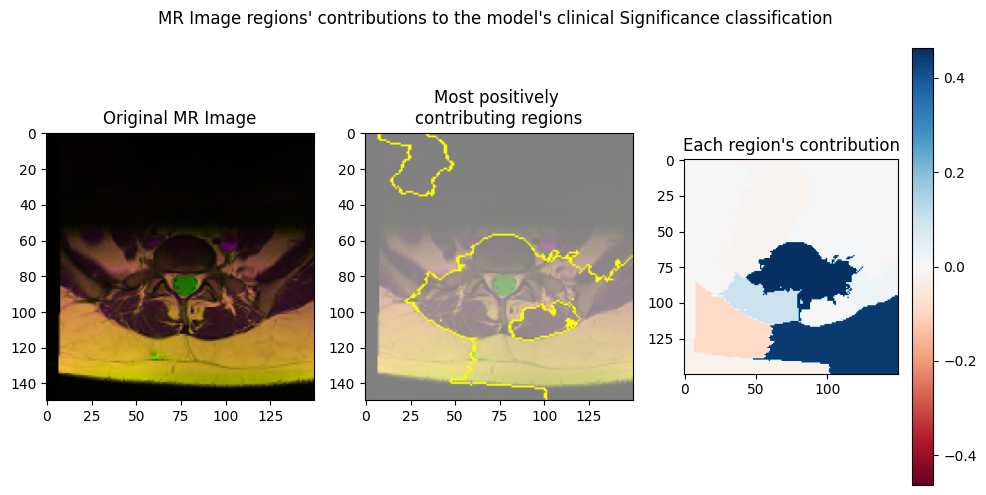

In [29]:
/# Select the same class explained on the figures above.
ind = explanation.top_labels[0]

# Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

# Get the original image and the mask for the top features
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Plot the original image to explain
plt.figure(figsize=(10, 5))
plt.suptitle("MR Image regions' contributions to the model's clinical Significance classification")
plt.subplot(1, 3, 1)
plt.imshow(image_to_explain)
plt.title('Original MR Image')

# Plot the superpixels (for the most positively contributing regions)
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Most positively \ncontributing regions')

# Plot the heatmap (each region's contribution)
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar()
plt.title("Each region's contribution")


plt.tight_layout()
plt.show()
